In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from exif import Image

In [3]:
BASE_DATA_PATH = '../data/raw/OCT2017/'
TRAIN_BASE_PATH = '../data/raw/OCT2017/train/'
TEST_BASE_PATH = '../data/raw/OCT2017/test/'

## Create Base Data

Write a program which imports all the metadata about the OCT files as a Pandas DataFrame

In [4]:
parents = ['train', 'test']
children = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# create a base dataframe from the directory items
names_cache = []
for p in parents:
    for c in children:
        files = os.listdir(os.path.join(BASE_DATA_PATH, p, c))
        instance_type = [ p for i in range(len(files)) ]
        path = [ f'/OCT2017/{p}/{c}' for i in range(len(files))]
        print(f'{p}/{c} contains {len(files)} files')
        names_cache.extend(list(zip(files, path, instance_type)))

oct_df = pd.DataFrame(names_cache, columns=['filename', 'path', 'type'])

# split filename into features
oct_df['disease'] = oct_df['filename'].apply(lambda f: f.split('-')[0])
oct_df['pat_id'] = oct_df['filename'].apply(lambda f: f.split('-')[1])
oct_df['img_id'] = oct_df['filename'].apply(lambda f: f.split('-')[2].split('.')[0])
oct_df['filetype'] = oct_df['filename'].apply(lambda f: f.split('.')[1])
oct_df

train/CNV contains 37205 files
train/DME contains 11348 files
train/DRUSEN contains 8616 files
train/NORMAL contains 26315 files
test/CNV contains 250 files
test/DME contains 250 files
test/DRUSEN contains 250 files
test/NORMAL contains 250 files


,filename,path,type,disease,pat_id,img_id,filetype
0,CNV-5557306-155.jpeg,/OCT2017/train/CNV,train,CNV,5557306,155,jpeg
1,CNV-163081-153.jpeg,/OCT2017/train/CNV,train,CNV,163081,153,jpeg
2,CNV-3537912-28.jpeg,/OCT2017/train/CNV,train,CNV,3537912,28,jpeg
3,CNV-7159021-147.jpeg,/OCT2017/train/CNV,train,CNV,7159021,147,jpeg
4,CNV-8087608-23.jpeg,/OCT2017/train/CNV,train,CNV,8087608,23,jpeg
...,...,...,...,...,...,...,...
84479,NORMAL-5246808-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,5246808,1,jpeg
84480,NORMAL-2733663-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,2733663,1,jpeg
84481,NORMAL-557437-2.jpeg,/OCT2017/test/NORMAL,test,NORMAL,557437,2,jpeg
84482,NORMAL-3059523-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,3059523,1,jpeg


## Check for Duplicate Data

Do some investigative queries:
- duplicate data

In [5]:
len(oct_df['filename'].unique())

83605

Looks to be 879 duplicate instances

In [6]:
duplicate_files = oct_df[oct_df['filename'].duplicated()]
duplicate_files = duplicate_files.sort_values(by=['filename'], ascending=True)
duplicate_files

,filename,path,type,disease,pat_id,img_id,filetype
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg
83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg
83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg
83501,CNV-1016042-4.jpeg,/OCT2017/test/CNV,test,CNV,1016042,4,jpeg
83656,CNV-103044-1.jpeg,/OCT2017/test/CNV,test,CNV,103044,1,jpeg
...,...,...,...,...,...,...,...
84346,NORMAL-84466-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,84466,1,jpeg
84429,NORMAL-85367-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,85367,1,jpeg
84368,NORMAL-9053621-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9053621,1,jpeg
84350,NORMAL-9251-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9251,1,jpeg


In [7]:
duplicate_files['type'].value_counts()

test    879
Name: type, dtype: int64

In [8]:
oct_df[oct_df.filename == 'CNV-1016042-1.jpeg']

,filename,path,type,disease,pat_id,img_id,filetype
26516,CNV-1016042-1.jpeg,/OCT2017/train/CNV,train,CNV,1016042,1,jpeg
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg


🔥 All duplicate files are replicated in both test and train directories. With the Pandas `duplicated()` method, we mark all items as duplicates except for the first occurrence. Since we traverse training directories first in the dataframe creation, all files in the test directory are marked as duplicates.
- 🔑 Potential Solution: Combine all training and test data and conduct a shuffle and (re)split of the data into a training, validation, and test set of images.

Testing if files have metadata associated with them

In [9]:
with open(os.path.join(BASE_DATA_PATH, 'train', 'CNV', 'CNV-1016042-1.jpeg'), 'rb') as i:
    img = Image(i)

print(img.get_all())

{}


Using free and online tools, some metadata does exist:
- image width: 768
- image heigh: 496

## Get Patient ID Counts

In [10]:
pat_df = pd.DataFrame(oct_df.groupby('pat_id').size()).reset_index()
pat_df.columns = ['pat_id', 'instance_count']
pat_df

,pat_id,instance_count
0,1001666,10
1,1001772,10
2,1004480,14
3,100580,8
4,1007507,2
...,...,...
4652,997190,16
4653,9983517,1
4654,9992052,2
4655,9997417,10


In [18]:
pat_df['instance_count'].describe()

count    4657.000000
mean       18.141293
std        42.736217
min         1.000000
25%         4.000000
50%         6.000000
75%        13.000000
max       817.000000
Name: instance_count, dtype: float64

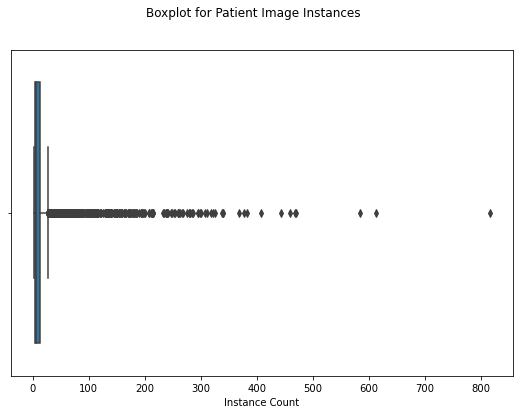

In [24]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.boxplot(data=pat_df, x='instance_count')

plt.show()

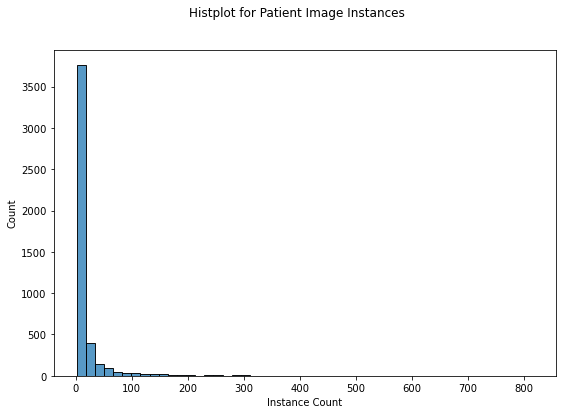

In [25]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.histplot(data=pat_df, x='instance_count', bins=50)
ax.set_xlabel('Instance Count')
plt.suptitle('Histplot for Patient Image Instances')
plt.show()

## Report
- 84,484 total instances
- 83,605 unique instances
    - train/CNV contains 37205 files
    - train/DME contains 11348 files
    - train/DRUSEN contains 8616 files
    - train/NORMAL contains 26315 files
    - test/CNV contains 250 files
    - test/DME contains 250 files
    - test/DRUSEN contains 250 files
    - test/NORMAL contains 250 files
- High standard deviation for number of instances per patient